In [1]:
from pathlib import Path
import gc
import sqlite3
import sys
import random
from collections import defaultdict
import numpy as np
import torch as th
from tqdm import tqdm
import time
import os

from transformers import AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

th.set_grad_enabled(False)

In [2]:
class LatentActivationCache:
    def __init__(
        self,
        latent_activations_dir: Path,
        expand=True,
        offset=0,
        use_sparse_tensor=False,
        device: th.device = None,
    ):
        if isinstance(latent_activations_dir, str):
            latent_activations_dir = Path(latent_activations_dir)

        # Create progress bar for 7 files to load
        pbar = tqdm(total=7, desc="Loading cache files")

        pbar.set_postfix_str("Loading out_acts.pt")
        self.acts = th.load(latent_activations_dir / "out_acts.pt", weights_only=True)
        pbar.update(1)

        pbar.set_postfix_str("Loading out_ids.pt")
        self.ids = th.load(latent_activations_dir / "out_ids.pt", weights_only=True)
        pbar.update(1)

        pbar.set_postfix_str("Loading max_activations.pt")
        self.max_activations = th.load(
            latent_activations_dir / "max_activations.pt", weights_only=True
        )
        pbar.update(1)

        pbar.set_postfix_str("Loading latent_ids.pt")
        self.latent_ids = th.load(
            latent_activations_dir / "latent_ids.pt", weights_only=True
        )
        pbar.update(1)

        pbar.set_postfix_str("Loading padded_sequences.pt")
        self.padded_sequences = th.load(
            latent_activations_dir / "padded_sequences.pt", weights_only=True
        )
        pbar.update(1)

        self.dict_size = self.max_activations.shape[0]

        pbar.set_postfix_str("Loading seq_lengths.pt")
        self.sequence_lengths = th.load(
            latent_activations_dir / "seq_lengths.pt", weights_only=True
        )
        pbar.update(1)

        pbar.set_postfix_str("Loading seq_ranges.pt")
        self.sequence_ranges = th.load(
            latent_activations_dir / "seq_ranges.pt", weights_only=True
        )
        pbar.update(1)
        pbar.close()

        self.expand = expand
        self.offset = offset
        self.use_sparse_tensor = use_sparse_tensor
        self.device = device
        if device is not None:
            self.to(device)

    def __len__(self):
        return len(self.padded_sequences) - self.offset

    def __getitem__(self, index: int):
        """
        Retrieves tokens and latent activations for a specific sequence.

        Args:
            index (int): The index of the sequence to retrieve.

        Returns:
            tuple: A pair containing:
                - The token sequence for the sample
                - If self.expand is True:
                    - If use_sparse_tensor is True:
                        A sparse tensor of shape (sequence_length, dict_size) containing the latent activations
                    - If use_sparse_tensor is False:
                        A dense tensor of shape (sequence_length, dict_size) containing the latent activations
                - If self.expand is False:
                    A tuple of (indices, values) representing sparse latent activations where:
                    - indices: Tensor of shape (N, 2) containing (token_idx, dict_idx) pairs
                    - values: Tensor of shape (N,) containing activation values
        """
        return self.get_sequence(index), self.get_latent_activations(
            index, expand=self.expand, use_sparse_tensor=self.use_sparse_tensor
        )

    def get_sequence(self, index: int):
        return self.padded_sequences[index + self.offset][
            : self.sequence_lengths[index + self.offset]
        ]

    def get_latent_activations(
        self, index: int, expand: bool = True, use_sparse_tensor: bool = False
    ):
        start_index = self.sequence_ranges[index + self.offset]
        end_index = self.sequence_ranges[index + self.offset + 1]
        seq_indices = self.ids[start_index:end_index]
        assert th.all(
            seq_indices[:, 0] == index + self.offset
        ), f"Was supposed to find {index + self.offset} but found {seq_indices[:, 0].unique()}"
        seq_indices = seq_indices[:, 1:]  # remove seq_idx column

        if expand:
            if use_sparse_tensor:
                # Create sparse tensor directly
                indices = (
                    seq_indices.t()
                )  # Transpose to get 2xN format required by sparse tensors
                values = self.acts[start_index:end_index]
                sparse_shape = (
                    self.sequence_lengths[index + self.offset],
                    self.dict_size,
                )
                return th.sparse_coo_tensor(indices, values, sparse_shape)
            else:
                # Create dense tensor as before
                latent_activations = th.zeros(
                    self.sequence_lengths[index + self.offset],
                    self.dict_size,
                    device=self.acts.device,
                )
                latent_activations[seq_indices[:, 0], seq_indices[:, 1]] = self.acts[
                    start_index:end_index
                ]
                return latent_activations
        else:
            return (seq_indices, self.acts[start_index:end_index])

    def to(self, device: th.device):
        self.acts = self.acts.to(device)
        self.ids = self.ids.to(device)
        self.max_activations = self.max_activations.to(device)
        self.latent_ids = self.latent_ids.to(device)
        self.padded_sequences = self.padded_sequences.to(device)
        self.device = device
        return self

In [3]:
def quantile_examples_to_db(
    quantile_examples, all_sequences, activation_details, db_path: Path
):
    """Convert quantile examples to a database with binary blob storage for token IDs.

    Args:
        quantile_examples: Dictionary mapping quantile_idx -> feature_idx -> list of (activation_value, sequence_idx)
        all_sequences: List of all sequences used in the examples
        activation_details: Dictionary mapping feature_idx -> sequence_idx -> list of (position, value) pairs
        db_path: Path to save the database
    """
    if db_path.exists():
        db_path.unlink()
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()

        # Create tables
        cursor.execute(
            """CREATE TABLE IF NOT EXISTS sequences (
                sequence_idx INTEGER PRIMARY KEY,
                token_ids BLOB
            )"""
        )

        cursor.execute(
            """CREATE TABLE IF NOT EXISTS quantile_examples (
                feature_idx INTEGER,
                quantile_idx INTEGER,
                activation REAL,
                sequence_idx INTEGER,
                PRIMARY KEY (feature_idx, sequence_idx),
                FOREIGN KEY (sequence_idx) REFERENCES sequences(sequence_idx)
            )"""
        )

        # First, store all sequences
        for seq_idx, token_ids in tqdm(
            enumerate(all_sequences), desc="Storing sequences"
        ):
            # Convert token IDs to binary blob
            binary_data = np.array(token_ids, dtype=np.int32).tobytes()
            cursor.execute(
                "INSERT INTO sequences VALUES (?, ?)",
                (int(seq_idx), binary_data),
            )

        # Then store the quantile examples with references to sequences
        for q_idx, q_data in tqdm(
            quantile_examples.items(), desc="Storing quantile examples"
        ):
            for feature_idx, examples in q_data.items():
                for activation, sequence_idx in examples:
                    # Get the max position from the original sequence
                    # This assumes we're still tracking max positions somewhere
                    # If not, we'd need to modify the compute_quantile_activating_examples function
                    # to also track positions along with activations

                    cursor.execute(
                        "INSERT INTO quantile_examples VALUES (?, ?, ?, ?)",
                        (
                            int(feature_idx),
                            int(q_idx),
                            float(activation),
                            int(sequence_idx),
                        ),
                    )

        # Create a table for storing activation details
        cursor.execute(
            """CREATE TABLE IF NOT EXISTS activation_details (
                feature_idx INTEGER,
                sequence_idx INTEGER,
                positions BLOB,
                activation_values BLOB,
                PRIMARY KEY (feature_idx, sequence_idx),
                FOREIGN KEY (sequence_idx) REFERENCES sequences(sequence_idx),
                FOREIGN KEY (feature_idx, sequence_idx) REFERENCES quantile_examples(feature_idx, sequence_idx)
            )"""
        )

        # After storing all quantile examples
        # Store activation details
        for feature_idx, sequences in tqdm(
            activation_details.items(), desc="Storing activation details"
        ):
            for sequence_idx, pos_val_pairs in sequences.items():
                if len(pos_val_pairs) == 0:
                    continue

                positions_blob = pos_val_pairs[:, 0].tobytes()
                values_blob = pos_val_pairs[:, 1].tobytes()

                cursor.execute(
                    "INSERT INTO activation_details VALUES (?, ?, ?, ?)",
                    (
                        int(feature_idx),
                        int(sequence_idx),
                        positions_blob,
                        values_blob,
                    ),
                )

        conn.commit()

In [18]:
@th.no_grad()
def compute_quantile_activating_examples(
    latent_activation_cache,
    quantiles=[0.25, 0.5, 0.75, 0.95],
    min_threshold=1e-4,
    n=100,
    save_path=None,
    gc_collect_every=1000,
    log_time=False,
    use_random_replacement=True,
    file_name: str = "examples",
) -> dict:
    """Compute examples that activate features at different quantile levels.

    Args:
        latent_activation_cache: Pre-computed latent activation cache
        quantiles: List of quantile thresholds (as fractions of max activation)
        min_threshold: Minimum activation threshold to consider
        n: Number of examples to collect per feature per quantile
        save_path: Path to save results
        gc_collect_every: How often to run garbage collection

    Returns:
        Tuple of (quantile_examples, all_sequences) where:
            - quantile_examples: Dictionary mapping quantile_idx -> feature_idx -> list of (activation_value, sequence_idx, position)
            - all_sequences: List of all token sequences used in the examples
    """
    log_time = log_time 
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    # Move max_activations and quantiles to GPU
    max_activations = latent_activation_cache.max_activations
    quantiles_tensor = th.tensor(quantiles, device=device)

    # Calculate quantile thresholds for each feature on GPU
    thresholds = th.einsum("f,q->fq", max_activations, quantiles_tensor)

    # Initialize collections for each quantile
    quantile_examples = {
        q_idx: {feat_idx: [] for feat_idx in range(len(max_activations))}
        for q_idx in range(len(quantiles) + 1)
    }

    # Keep track of how many examples we've seen for each feature and quantile
    example_counts = {
        q_idx: {feat_idx: 0 for feat_idx in range(len(max_activations))}
        for q_idx in range(len(quantiles) + 1)
    }

    # Store all unique sequences
    sequences_set = set()
    all_sequences = []

    # Dictionary to store feature activation details: {feature_idx: {sequence_idx: [(position, value), ...]}}
    activation_details = defaultdict(dict)

    timings = defaultdict(list)  # Changed to list to store all iterations

    def _log_time(section, start_time, add=False):
        if not log_time:
            return None
        elapsed = time.time() - start_time
        if add:
            timings[section][-1] += elapsed
        else:
            timings[section].append(elapsed)
        return time.time()

    next_gb = gc_collect_every
    current_seq_idx = 0
    for tokens, (indices, values) in tqdm(latent_activation_cache):
        iter_start = time.time() if log_time else None

        # GC and device transfer timing
        next_gb -= 1
        if next_gb <= 0:
            gc.collect()
            next_gb = gc_collect_every
            
        current = _log_time("1. GC and device transfer", iter_start)

        token_tuple = tuple(tokens.tolist())
        if token_tuple in sequences_set:
            continue
        sequences_set.add(token_tuple)
        all_sequences.append(token_tuple)
        current = _log_time("2. Sequence processing", current)

        # Core computation timing
        features, sort_indices = th.sort(indices[:, 1])
        token_indices = indices[:, 0][sort_indices]
        values = values[sort_indices]
        active_features, inverse_indices, counts = features.unique(
            return_inverse=True, return_counts=True
        )
        max_vals = th.zeros_like(active_features, dtype=values.dtype)
        max_vals = th.scatter_reduce(
            max_vals, 0, inverse_indices, values, reduce="amax"
        )

        active_thresholds = thresholds[active_features]

        q_idxs = th.searchsorted(active_thresholds, max_vals.unsqueeze(-1)).squeeze()

        current_preloop = _log_time("3. Core computation", current)

        active_features = active_features.view(-1).tolist()
        counts = counts.view(-1).tolist()
        max_vals = max_vals.view(-1).tolist()
        q_idxs = q_idxs.view(-1).tolist()
        # max_values =
        # Example collection timing
        current_idx = 0
        latent_details = (
            th.stack(
                [token_indices.int(), values.float().view(th.int32)],
                dim=1,
            )
            .cpu()
            .numpy()
        )

        current = _log_time("4. move and convert to numpy", current)
        if log_time:
            for times in [
                "loop1",
                "loop2",
                "loop3",
                "update_details",
            ]:
                timings[times].append(0)

        for feat, count, max_val, q_idx in zip(
            active_features,
            counts,
            # inverse_indices,
            max_vals,
            q_idxs,
        ):
            current = time.time() if log_time else None
            example_counts[q_idx][feat] += 1
            total_count = example_counts[q_idx][feat]

            if total_count <= n:
                quantile_examples[q_idx][feat].append((max_val, current_seq_idx))
                current = _log_time("loop1", current, add=True)
                # Time the activation details collection
                activation_details[feat][current_seq_idx] = latent_details[
                    current_idx : current_idx + count
                ]
                _log_time("update_details", current, add=True)
            elif use_random_replacement:
                if random.random() < n / total_count:
                    replace_idx = random.randint(0, n - 1)
                    replaced_seq_idx = quantile_examples[q_idx][feat][replace_idx][1]
                    quantile_examples[q_idx][feat][replace_idx] = (
                        max_val,
                        current_seq_idx,
                    )
                    current = _log_time("loop2", current, add=True)
                    if (
                        feat in activation_details
                        and replaced_seq_idx in activation_details[feat]
                    ):
                        del activation_details[feat][replaced_seq_idx]
                    current = _log_time("loop3", current, add=True)
                    activation_details[feat][current_seq_idx] = latent_details[
                        current_idx : current_idx + count
                    ]
                    _log_time("update_details", current, add=True)
            current_idx += count

        current = _log_time(
            "5. Example collection and activation details", current_preloop
        )
        if (
            len(timings["5. Example collection and activation details"]) % 10 == 0
            and log_time
        ):  # Print periodically
            print("\nCurrent mean timings per iteration:")
            for section, times in timings.items():
                mean_time = sum(times) / len(times)
                print(f"{section}: {mean_time:.4f}s")
        current_seq_idx += 1

    if log_time:
        print("\nFinal timings:")
        for section, times in timings.items():
            mean_time = sum(times) / len(times)
            print(f"{section}: {mean_time:.4f}s")

    # Sort and finalize results
    print(f"Sorting {len(quantile_examples)} quantiles")
    quantile_examples = sort_quantile_examples(quantile_examples)
    name = file_name
    # Save to database
    if save_path is not None:
        print(f"Saving to {save_path / f'{name}.db'}")
        quantile_examples_to_db(
            quantile_examples,
            all_sequences,
            activation_details,
            save_path / f"{name}.db",
        )
        print(f"Saving to {save_path / f'{name}.pt'}")
        # Also save as PyTorch file for compatibility

    activation_details = fix_activations_details(activation_details)
    if save_path is not None:
        th.save(
            (quantile_examples, all_sequences, activation_details),
            save_path / f"{name}.pt",
        )

    return quantile_examples, all_sequences, activation_details

In [5]:
def fix_activations_details(activation_details):
    """Convert activation details from int32 arrays to tuples of (positions, values) with proper types."""
    converted = {}
    for feat_idx, sequences in activation_details.items():
        converted[feat_idx] = {}
        for seq_idx, arr in sequences.items():
            # arr is a Nx2 array where first column is positions (int) and second column is values (float as int32)
            positions = arr[:, 0].astype(np.int32)
            # Convert back the int32 values to float32
            values = arr[:, 1].view(np.float32)
            converted[feat_idx][seq_idx] = (positions, values)
    return converted


def sort_quantile_examples(quantile_examples):
    """Sort quantile examples by activation value."""
    for q_idx in quantile_examples:
        for feature_idx in quantile_examples[q_idx]:
            quantile_examples[q_idx][feature_idx] = sorted(
                quantile_examples[q_idx][feature_idx],
                key=lambda x: x[0],
                reverse=True,
            )
    return quantile_examples

In [6]:
def collect_activating_examples(
    crosscoder: str,
    latent_activation_cache: LatentActivationCache,
    bos_token_id: int = 2,
    n: int = 100,
    min_threshold: float = 1e-4,
    quantiles: list[float] = [0.25, 0.5, 0.75, 0.95, 1.0],
    save_path: Path = Path("quantile_examples"),
    file_name: str = "examples",
) -> None:
    """
    Collect and save examples that activate latent features at different quantiles.

    This function processes latent activations to find examples that activate features
    at specified quantile thresholds. It can optionally save results locally and/or
    upload them to HuggingFace Hub.

    Args:
        crosscoder (str): Name of the crosscoder model to analyze
        latent_activation_cache_path (Path): Path to directory containing latent activation data
        bos_token_id (int, optional): Beginning of sequence token ID. Defaults to 2.
        n (int, optional): Number of examples to collect per quantile. Defaults to 100.
        min_threshold (float, optional): Minimum activation threshold. Defaults to 1e-4.
        quantiles (list[float], optional): Quantile thresholds to analyze.
            Defaults to [0.25, 0.5, 0.75, 0.95, 1.0].
        save_path (Path, optional): Directory to save results.
            Defaults to Path("results/quantile_examples").
        only_upload (bool, optional): If True, only upload existing results to HuggingFace.
            Defaults to False.

    Returns:
        None
    """
    save_path = save_path / crosscoder

    # Create save directory if it doesn't exist
    save_path.mkdir(parents=True, exist_ok=True)

    # Generate and save quantile examples
    print("Generating quantile examples...")
    compute_quantile_activating_examples(
        latent_activation_cache=latent_activation_cache,
        quantiles=quantiles,
        min_threshold=min_threshold,
        n=n,
        save_path=save_path,
        file_name=file_name,
    )

In [182]:
device = "cuda" if th.cuda.is_available() else "cpu"
path = "/pscratch/sd/r/ritesh11/temp_dir/latent_activations/crosscoder"

NameError: name 'th' is not defined

In [183]:
latent_activation_cache = LatentActivationCache(
    path,
    expand=False,
).to(device)

NameError: name 'LatentActivationCache' is not defined

In [184]:
from transformers import AutoTokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained("Qwen3-1.7B")

In [19]:
collect_activating_examples(
    crosscoder='crosscoder',
    latent_activation_cache=latent_activation_cache,
    bos_token_id=tokenizer.bos_token_id,
)

Generating quantile examples...


100%|██████████| 7936/7936 [00:06<00:00, 1205.06it/s]


Sorting 6 quantiles
Saving to quantile_examples/crosscoder/examples.db


Storing sequences: 7901it [00:00, 8506.32it/s]
Storing activation details: 100%|██████████| 16/16 [00:00<00:00, 347.17it/s]


Saving to quantile_examples/crosscoder/examples.pt


In [30]:
import torch
qe, seqs, activation_details = torch.load("/pscratch/sd/r/ritesh11/temp_dir/quantile_examples/crosscoder/examples.pt",weights_only=False)

print(type(qe))   # dict: quantile_idx → feature_id → examples
print(len(seqs))  # list of all token sequences
print(len(activation_details))

<class 'dict'>
7901
16


In [31]:
from transformers import AutoTokenizer

In [32]:
tokenizer = AutoTokenizer.from_pretrained("Qwen3-1.7B")

In [33]:
import html
from IPython.display import display, HTML

def visualize_activations(feature_idx, sequence_idx):
    """Highlight activations in the detokenized sentence, aligned to token positions."""

    token_ids = seqs[sequence_idx]

    if sequence_idx not in activation_details[feature_idx]:
        print(f"No activations for feature {feature_idx} in sequence {sequence_idx}")
        return

    positions, values = activation_details[feature_idx][sequence_idx]


    if len(values) > 0:
        max_act_in_seq = float(values.max())
    else:
        max_act_in_seq = 1.0

    act_map = {int(pos): float(val) for pos, val in zip(positions, values)}

    # --- Decode once for clean text ---
    decoded_text = tokenizer.decode(token_ids, clean_up_tokenization_spaces=False)

    # --- Re-tokenize decoded text to get offsets ---
    encoding = tokenizer(
        decoded_text,
        return_offsets_mapping=True,
        add_special_tokens=False
    )

    html_output = ""
    last_end = 0
    offsets = encoding["offset_mapping"]

    for i, (start, end) in enumerate(offsets):
        # plain text between tokens
        html_output += html.escape(decoded_text[last_end:start])

        token_text = decoded_text[start:end]
        escaped_token = html.escape(token_text)

        if i in act_map:
            intensity = act_map[i] / max_act_in_seq
            color = f"rgba(255, 0, 0, {intensity:.2f})"
            html_output += (
                f'<span style="background-color: {color}" '
                f'title="Activation: {act_map[i]:.2f}">{escaped_token}</span>'
            )
        else:
            html_output += escaped_token

        last_end = end

    # trailing text
    html_output += html.escape(decoded_text[last_end:])

    display(
        HTML(
            f"<div style='font-family: monospace; white-space: pre-wrap;'>{html_output}</div>"
        )
    )

In [40]:
# --- 3. Decode and display the top examples for your chosen feature ---

feature_idx_to_analyze = 2
quantile_to_analyze = 3 # 4 is the strongest, 0 is the weakest

# Get the list of examples for this feature and quantile
examples_bin = qe[quantile_to_analyze][feature_idx_to_analyze]

# Sort the examples by activation strength (descending) to see the best ones first
examples_bin.sort(key=lambda x: x[0], reverse=True)


In [41]:
len(examples_bin)

12

In [47]:
act, top_sequence_idx = examples_bin[8]
print(f"Visualizing Feature {feature_idx_to_analyze} on Sequence {top_sequence_idx}")
visualize_activations(feature_idx_to_analyze, top_sequence_idx)

Visualizing Feature 2 on Sequence 6350


In [52]:
from datasets import load_from_disk

In [53]:
true_val_data = load_from_disk("MATS_true_processed/")
false_val_data = load_from_disk("MATS_false_processed/")

In [56]:
true_set = set(true_val_data['test']['text'])
false_set = set(false_val_data['test']['text'])

In [73]:
import os
from tqdm import tqdm

# Map of true feature indices
true_feature_idxs = [
    1774, 3609, 6425, 15943, 18232, 24833, 30340, 
    36090, 43592, 44647, 51653, 51802, 53929, 56428, 
    57787, 58237
]


# Iterate over features and quantiles
feats_false_counts = {}
for feat_idx, true_idx in enumerate(true_feature_idxs):
    counter = 0
    total = 0
    for quantile in range(1,5):

        examples_bin = qe[quantile][feat_idx]
        print(f"Feature {true_idx}, quantile {quantile}: {len(examples_bin)} examples")

        # Use tqdm for progress bar
        for _, seq_idx in tqdm(examples_bin, desc=f"Feature {true_idx}, Q{quantile}"):
            if tokenizer.decode(seqs[seq_idx]) in false_set:
                counter+=1
            total+=1
    feats_false_counts[true_idx] = (counter,total)
                


Feature 1774, quantile 1: 85 examples


Feature 1774, Q1: 100%|██████████| 85/85 [00:00<00:00, 1192.09it/s]


Feature 1774, quantile 2: 31 examples


Feature 1774, Q2: 100%|██████████| 31/31 [00:00<00:00, 1410.14it/s]


Feature 1774, quantile 3: 19 examples


Feature 1774, Q3: 100%|██████████| 19/19 [00:00<00:00, 936.16it/s]


Feature 1774, quantile 4: 4 examples


Feature 1774, Q4: 100%|██████████| 4/4 [00:00<00:00, 1438.62it/s]


Feature 3609, quantile 1: 100 examples


Feature 3609, Q1: 100%|██████████| 100/100 [00:00<00:00, 1341.15it/s]


Feature 3609, quantile 2: 100 examples


Feature 3609, Q2: 100%|██████████| 100/100 [00:00<00:00, 1359.88it/s]


Feature 3609, quantile 3: 22 examples


Feature 3609, Q3: 100%|██████████| 22/22 [00:00<00:00, 1379.48it/s]


Feature 3609, quantile 4: 2 examples


Feature 3609, Q4: 100%|██████████| 2/2 [00:00<00:00, 1396.70it/s]


Feature 6425, quantile 1: 100 examples


Feature 6425, Q1: 100%|██████████| 100/100 [00:00<00:00, 1198.74it/s]


Feature 6425, quantile 2: 77 examples


Feature 6425, Q2: 100%|██████████| 77/77 [00:00<00:00, 1459.98it/s]


Feature 6425, quantile 3: 12 examples


Feature 6425, Q3: 100%|██████████| 12/12 [00:00<00:00, 1360.24it/s]


Feature 6425, quantile 4: 4 examples


Feature 6425, Q4: 100%|██████████| 4/4 [00:00<00:00, 1067.19it/s]


Feature 15943, quantile 1: 100 examples


Feature 15943, Q1: 100%|██████████| 100/100 [00:00<00:00, 1348.39it/s]


Feature 15943, quantile 2: 100 examples


Feature 15943, Q2: 100%|██████████| 100/100 [00:00<00:00, 1226.19it/s]


Feature 15943, quantile 3: 55 examples


Feature 15943, Q3: 100%|██████████| 55/55 [00:00<00:00, 1224.25it/s]


Feature 15943, quantile 4: 1 examples


Feature 15943, Q4: 100%|██████████| 1/1 [00:00<00:00, 1178.18it/s]


Feature 18232, quantile 1: 100 examples


Feature 18232, Q1: 100%|██████████| 100/100 [00:00<00:00, 1290.48it/s]


Feature 18232, quantile 2: 100 examples


Feature 18232, Q2: 100%|██████████| 100/100 [00:00<00:00, 1334.74it/s]


Feature 18232, quantile 3: 42 examples


Feature 18232, Q3: 100%|██████████| 42/42 [00:00<00:00, 1187.85it/s]


Feature 18232, quantile 4: 2 examples


Feature 18232, Q4: 100%|██████████| 2/2 [00:00<00:00, 942.75it/s]


Feature 24833, quantile 1: 100 examples


Feature 24833, Q1: 100%|██████████| 100/100 [00:00<00:00, 1378.41it/s]


Feature 24833, quantile 2: 100 examples


Feature 24833, Q2: 100%|██████████| 100/100 [00:00<00:00, 1427.58it/s]


Feature 24833, quantile 3: 11 examples


Feature 24833, Q3: 100%|██████████| 11/11 [00:00<00:00, 1486.96it/s]


Feature 24833, quantile 4: 1 examples


Feature 24833, Q4: 100%|██████████| 1/1 [00:00<00:00, 949.58it/s]


Feature 30340, quantile 1: 100 examples


Feature 30340, Q1: 100%|██████████| 100/100 [00:00<00:00, 1365.55it/s]


Feature 30340, quantile 2: 100 examples


Feature 30340, Q2: 100%|██████████| 100/100 [00:00<00:00, 1220.34it/s]


Feature 30340, quantile 3: 22 examples


Feature 30340, Q3: 100%|██████████| 22/22 [00:00<00:00, 1069.21it/s]


Feature 30340, quantile 4: 2 examples


Feature 30340, Q4: 100%|██████████| 2/2 [00:00<00:00, 1014.34it/s]


Feature 36090, quantile 1: 100 examples


Feature 36090, Q1: 100%|██████████| 100/100 [00:00<00:00, 1305.50it/s]


Feature 36090, quantile 2: 100 examples


Feature 36090, Q2: 100%|██████████| 100/100 [00:00<00:00, 1530.83it/s]


Feature 36090, quantile 3: 100 examples


Feature 36090, Q3: 100%|██████████| 100/100 [00:00<00:00, 1471.92it/s]


Feature 36090, quantile 4: 8 examples


Feature 36090, Q4: 100%|██████████| 8/8 [00:00<00:00, 1393.57it/s]


Feature 43592, quantile 1: 100 examples


Feature 43592, Q1: 100%|██████████| 100/100 [00:00<00:00, 1256.75it/s]


Feature 43592, quantile 2: 100 examples


Feature 43592, Q2: 100%|██████████| 100/100 [00:00<00:00, 1590.96it/s]


Feature 43592, quantile 3: 96 examples


Feature 43592, Q3: 100%|██████████| 96/96 [00:00<00:00, 1796.91it/s]


Feature 43592, quantile 4: 6 examples


Feature 43592, Q4: 100%|██████████| 6/6 [00:00<00:00, 1702.35it/s]


Feature 44647, quantile 1: 100 examples


Feature 44647, Q1: 100%|██████████| 100/100 [00:00<00:00, 1318.05it/s]


Feature 44647, quantile 2: 100 examples


Feature 44647, Q2: 100%|██████████| 100/100 [00:00<00:00, 1366.25it/s]


Feature 44647, quantile 3: 66 examples


Feature 44647, Q3: 100%|██████████| 66/66 [00:00<00:00, 1300.10it/s]


Feature 44647, quantile 4: 1 examples


Feature 44647, Q4: 100%|██████████| 1/1 [00:00<00:00, 923.65it/s]


Feature 51653, quantile 1: 100 examples


Feature 51653, Q1: 100%|██████████| 100/100 [00:00<00:00, 1340.68it/s]


Feature 51653, quantile 2: 76 examples


Feature 51653, Q2: 100%|██████████| 76/76 [00:00<00:00, 1245.21it/s]


Feature 51653, quantile 3: 10 examples


Feature 51653, Q3: 100%|██████████| 10/10 [00:00<00:00, 1090.00it/s]


Feature 51653, quantile 4: 2 examples


Feature 51653, Q4: 100%|██████████| 2/2 [00:00<00:00, 1193.77it/s]


Feature 51802, quantile 1: 100 examples


Feature 51802, Q1: 100%|██████████| 100/100 [00:00<00:00, 1444.81it/s]


Feature 51802, quantile 2: 100 examples


Feature 51802, Q2: 100%|██████████| 100/100 [00:00<00:00, 1452.73it/s]


Feature 51802, quantile 3: 100 examples


Feature 51802, Q3: 100%|██████████| 100/100 [00:00<00:00, 1385.52it/s]


Feature 51802, quantile 4: 3 examples


Feature 51802, Q4: 100%|██████████| 3/3 [00:00<00:00, 1698.56it/s]


Feature 53929, quantile 1: 100 examples


Feature 53929, Q1: 100%|██████████| 100/100 [00:00<00:00, 1361.69it/s]


Feature 53929, quantile 2: 100 examples


Feature 53929, Q2: 100%|██████████| 100/100 [00:00<00:00, 1446.69it/s]


Feature 53929, quantile 3: 46 examples


Feature 53929, Q3: 100%|██████████| 46/46 [00:00<00:00, 1450.23it/s]


Feature 53929, quantile 4: 3 examples


Feature 53929, Q4: 100%|██████████| 3/3 [00:00<00:00, 1289.10it/s]


Feature 56428, quantile 1: 100 examples


Feature 56428, Q1: 100%|██████████| 100/100 [00:00<00:00, 1387.00it/s]


Feature 56428, quantile 2: 100 examples


Feature 56428, Q2: 100%|██████████| 100/100 [00:00<00:00, 1379.12it/s]


Feature 56428, quantile 3: 78 examples


Feature 56428, Q3: 100%|██████████| 78/78 [00:00<00:00, 1272.88it/s]


Feature 56428, quantile 4: 2 examples


Feature 56428, Q4: 100%|██████████| 2/2 [00:00<00:00, 969.67it/s]


Feature 57787, quantile 1: 100 examples


Feature 57787, Q1: 100%|██████████| 100/100 [00:00<00:00, 1331.03it/s]


Feature 57787, quantile 2: 100 examples


Feature 57787, Q2: 100%|██████████| 100/100 [00:00<00:00, 1417.02it/s]


Feature 57787, quantile 3: 38 examples


Feature 57787, Q3: 100%|██████████| 38/38 [00:00<00:00, 1153.62it/s]


Feature 57787, quantile 4: 1 examples


Feature 57787, Q4: 100%|██████████| 1/1 [00:00<00:00, 872.54it/s]


Feature 58237, quantile 1: 100 examples


Feature 58237, Q1: 100%|██████████| 100/100 [00:00<00:00, 1382.94it/s]


Feature 58237, quantile 2: 100 examples


Feature 58237, Q2: 100%|██████████| 100/100 [00:00<00:00, 1353.90it/s]


Feature 58237, quantile 3: 47 examples


Feature 58237, Q3: 100%|██████████| 47/47 [00:00<00:00, 1277.85it/s]


Feature 58237, quantile 4: 6 examples


Feature 58237, Q4: 100%|██████████| 6/6 [00:00<00:00, 1057.12it/s]


{1774: (132, 139),
 3609: (218, 224),
 6425: (181, 193),
 15943: (243, 256),
 18232: (219, 244),
 24833: (199, 212),
 30340: (203, 224),
 36090: (205, 308),
 43592: (285, 302),
 44647: (219, 267),
 51653: (162, 188),
 51802: (286, 303),
 53929: (239, 249),
 56428: (249, 280),
 57787: (221, 239),
 58237: (238, 253)}

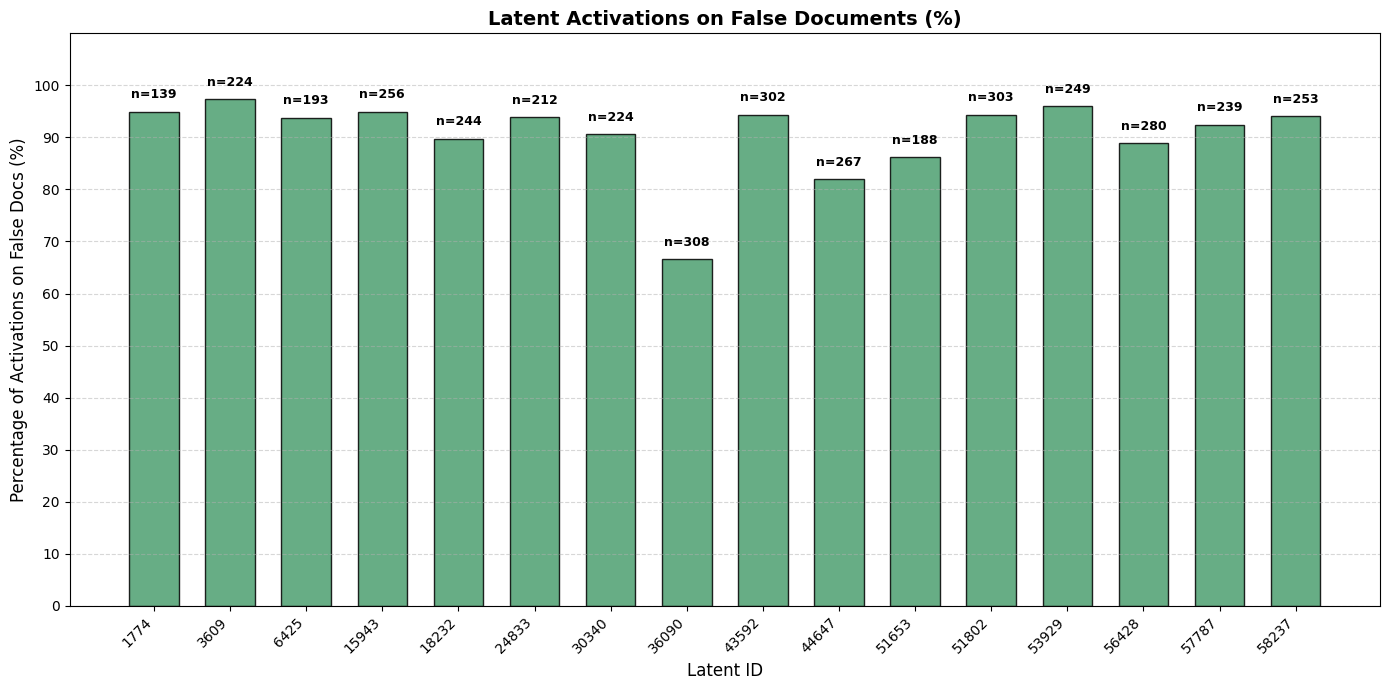

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = feats_false_counts

latent_idx = list(data.keys())
false_docs = [v[0] for v in data.values()]
total_docs = [v[1] for v in data.values()]
ratios = [f / t * 100 for f, t in data.values()]  # percentage

x = np.arange(len(latent_idx))
width = 0.65

# Choose one clean, modern color
bar_color = "#4C9F70"  # a soft teal green-blue

plt.figure(figsize=(14, 7))
bars = plt.bar(x, ratios, width, color=bar_color, edgecolor="black", alpha=0.85)

# Annotate each bar with total samples
for bar, total in zip(bars, total_docs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, 
             f"n={total}", ha="center", va="bottom", fontsize=9, fontweight="bold")

# Formatting
plt.xticks(x, latent_idx, rotation=45, ha="right", fontsize=10)
plt.yticks(np.arange(0, 110, 10), fontsize=10)
plt.ylabel("Percentage of Activations on False Docs (%)", fontsize=12)
plt.xlabel("Latent ID", fontsize=12)
plt.title("Latent Activations on False Documents (%)", fontsize=14, fontweight="bold")

plt.ylim(0, 110)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("latent_activations_falsepercentage.png", dpi=300, bbox_inches="tight")
plt.show()